In [1]:
%matplotlib inline

In [2]:
import pandas as pd
from datetime import datetime as dt
import datetime
import time
from matplotlib import pyplot as plt
import numpy as np

In [3]:
def get_timedelta(column1, column2):
    """ Returns total time elapsed by taking difference of when customer placed order and when order was delivered."""
    FMT = '%d %H:%M:%S'
    t1 = []
    t2 = []
    for a,b in zip(column1, column2):
        t1.append(dt.strptime(a,FMT))
        t2.append(dt.strptime(b,FMT))
        
    timedelta = [b-a for a,b in zip(t1,t2)]
    return timedelta

In [4]:
def hours_convert(array):
    """Converts an array of timedeltas to hours."""
    return [h.total_seconds()/3600 for h in array]

In [5]:
# Read in doordash data as dataframe.
dash = pd.DataFrame(pd.read_csv('resources/Analytics_Sample_Data_rsc.csv'))
# Calculate total time elapsed and append to data frame.
dash["Total time elapsed"] = get_timedelta(dash.iloc[:,0], dash.iloc[:,3])

dash.head()

,Customer_placed_order_datetime,Placed_order_with_restaurant_datetime,Driver_at_restaurant_datetime,Delivered_to_consumer_datetime,Driver_ID,Restaurant_ID,Consumer_ID,Is_New,Delivery_Region,Is_ASAP,Order_total,Amount_of_discount,Amount_of_tip,Refunded_amount,Total time elapsed
0,14 20:27:45,14 20:29:41,14 20:39:32,14 20:52:03,86,12,5,False,Palo Alto,True,20.45,20.45,3.07,0.0,00:24:18
1,07 20:16:28,07 20:17:32,07 20:36:00,07 20:49:02,325,66,5,False,Palo Alto,True,40.62,40.62,3.73,0.0,00:32:34
2,13 19:35:09,13 19:39:26,13 20:28:16,13 20:52:44,200,124,5,False,Palo Alto,True,37.78,37.78,1.89,0.0,01:17:35
3,22 19:47:53,22 19:56:08,22 20:01:20,22 20:18:01,154,5,14,False,Palo Alto,True,39.66,0.00,1.98,0.0,00:30:08
4,03 19:01:52,03 19:09:08,03 19:36:20,03 19:45:26,332,9,14,False,Palo Alto,True,39.66,0.00,5.95,0.0,00:43:34


In [6]:
# longest trip on here was 4 days long! Typo on the system or are orders really that long? Perhaps it was a catering order?
# Further digging reveals that this was an order scheduled in advance. Makes more sense now.
dash["Total time elapsed"].idxmax()
pd.DataFrame(dash.iloc[1937,:])

,1937
Customer_placed_order_datetime,04 18:02:27
Placed_order_with_restaurant_datetime,07 18:04:33
Driver_at_restaurant_datetime,08 23:50:08
Delivered_to_consumer_datetime,09 00:04:54
Driver_ID,286
Restaurant_ID,19
Consumer_ID,1934
Is_New,False
Delivery_Region,Palo Alto
Is_ASAP,False


In [7]:
# Get a quick overview of the data we just crunched. 
# Median delivery time is about 48 min for all regions.
pd.DataFrame(dash["Total time elapsed"].describe())

,Total time elapsed
count,18078
mean,-1 days +23:05:46.604491
std,1 days 16:51:27.895913
min,-31 days +00:25:11
25%,0 days 00:37:11
50%,0 days 00:48:15
75%,0 days 01:05:30.750000
max,4 days 06:02:27


In [8]:
# Show position of where the minimum value occurs
dash["Total time elapsed"].idxmin()
shortest_time = dash.loc[7515, ["Total time elapsed"]]
print(shortest_time)

Total time elapsed    -31 days +00:25:11
Name: 7515, dtype: object


In [9]:
# Grab data where the timedelta was nonzero and total time elapsed was less than 12 hours.
same_day = dash.loc[(dash["Total time elapsed"] > str(datetime.timedelta(seconds=0)))\
                    & (dash["Total time elapsed"] < str(datetime.timedelta(hours=12))),:]
same_day.head()

,Customer_placed_order_datetime,Placed_order_with_restaurant_datetime,Driver_at_restaurant_datetime,Delivered_to_consumer_datetime,Driver_ID,Restaurant_ID,Consumer_ID,Is_New,Delivery_Region,Is_ASAP,Order_total,Amount_of_discount,Amount_of_tip,Refunded_amount,Total time elapsed
0,14 20:27:45,14 20:29:41,14 20:39:32,14 20:52:03,86,12,5,False,Palo Alto,True,20.45,20.45,3.07,0.0,00:24:18
1,07 20:16:28,07 20:17:32,07 20:36:00,07 20:49:02,325,66,5,False,Palo Alto,True,40.62,40.62,3.73,0.0,00:32:34
2,13 19:35:09,13 19:39:26,13 20:28:16,13 20:52:44,200,124,5,False,Palo Alto,True,37.78,37.78,1.89,0.0,01:17:35
3,22 19:47:53,22 19:56:08,22 20:01:20,22 20:18:01,154,5,14,False,Palo Alto,True,39.66,0.00,1.98,0.0,00:30:08
4,03 19:01:52,03 19:09:08,03 19:36:20,03 19:45:26,332,9,14,False,Palo Alto,True,39.66,0.00,5.95,0.0,00:43:34


In [10]:
hours = hours_convert(dash["Total time elapsed"])

# Convert all time to hours and grab refunds greater than 1. aka when a customer initiated a refund.
refund = dash[["Refunded_amount", "Total time elapsed", "Is_ASAP"]]
refund["Total time elapsed"] = hours
refund = refund[(refund["Refunded_amount"] > 0) & (refund["Is_ASAP"]==True)]

C:\Users\Rafael\Anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [11]:
# Round up the total time elapsed to 1 decimal place and update the column..
refund["Total time elapsed"] = [round(x,1) for x in refund["Total time elapsed"]]

# Get counts for refunds and group them by the total time elapsed. Grabbing counts greater than 2.
refund_group = pd.DataFrame(refund.groupby("Total time elapsed")["Refunded_amount"].count())
refund_group = refund_group[(refund_group["Refunded_amount"]) > 1]

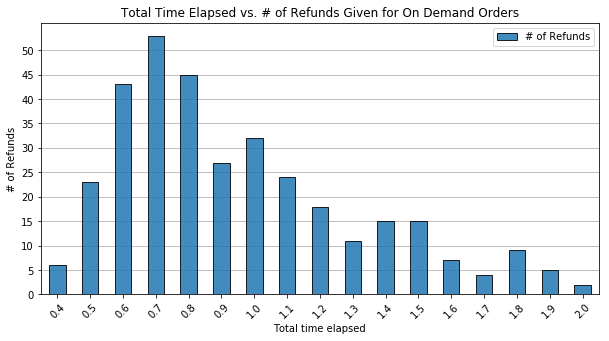

In [18]:
# Ploting grouped data frame
refund_group.plot(kind="bar",
                  figsize=(10,5),
                  width=.5, 
                  edgecolor="black",
                  zorder=3,
                  alpha=.85)

plt.title("Total Time Elapsed vs. # of Refunds Given for On Demand Orders")
plt.legend(["# of Refunds"])
plt.ylabel("# of Refunds")
plt.grid(axis="y",zorder=0)
plt.yticks(np.arange(0,55,5))
plt.xticks(rotation=45)
plt.savefig("time_elapsed_vs_refunds.png")
plt.show()

In [13]:
# Get all On Demand orders
time_asap = dash[(dash["Is_ASAP"] == True)]
# Looking at an overview of time elapsed for On Demand orders.
pd.DataFrame(time_asap["Total time elapsed"].describe())

,Total time elapsed
count,14435
mean,-1 days +23:57:24.518669
std,1 days 00:45:56.611337
min,-31 days +00:25:11
25%,0 days 00:35:06
50%,0 days 00:43:49
75%,0 days 00:55:19.500000
max,2 days 23:48:07


In [14]:
time_asap["Total time elapsed"] = hours_convert(time_asap["Total time elapsed"])

C:\Users\Rafael\Anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [15]:
time_asap = time_asap[(time_asap["Total time elapsed"] > 0)\
                      & (time_asap["Total time elapsed"] < 4)]

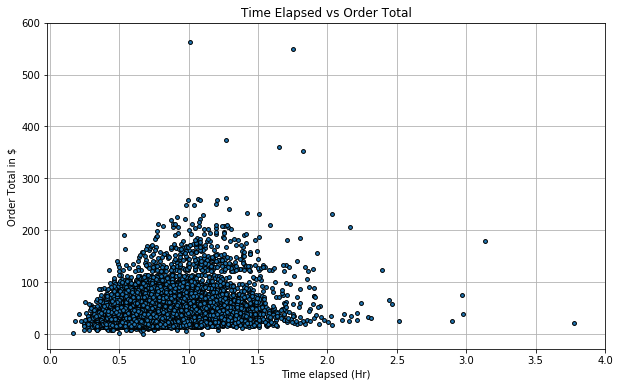

In [16]:
plt.figure(figsize=(10,6))

plt.grid(zorder=0)
plt.scatter(x=time_asap["Total time elapsed"], y=time_asap["Order_total"], s= 15,zorder=3,edgecolor="black")
plt.title("Time Elapsed vs Order Total")
plt.xlabel("Time elapsed (Hr)")
plt.ylabel("Order Total in $")
plt.xticks(np.arange(0,4.01, 0.5))
plt.yticks(np.arange(0,601,100))
plt.savefig("time_elapsed_vs_order_total.png")
plt.show()

In [17]:
time_asap["Total time elapsed"].idxmax()
pd.DataFrame(dash.iloc[14810,:])

,14810
Customer_placed_order_datetime,10 00:08:16
Placed_order_with_restaurant_datetime,12 20:08:14
Driver_at_restaurant_datetime,12 23:17:26
Delivered_to_consumer_datetime,12 23:56:23
Driver_ID,216
Restaurant_ID,9
Consumer_ID,85535
Is_New,False
Delivery_Region,Palo Alto
Is_ASAP,True
